In [4]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_26884\696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from datetime import timedelta
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
import datetime as dt
import random
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.2
numpy version: 1.21.5


In [6]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

In [7]:
%matplotlib notebook
# Plot related packages,%matplotlib notebook makes plots in jupyter interactive
# constants for plotting
x_label_elapsedtime = 0
x_label_datetime = 1

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [7]:
# Load raw data
import pickle
    
# load last saved df from phase1 data as segments of freq 1 Hz
dir_path = os.path.join(cwd, 'csv', 'phase_1_pkl')
src_path = os.path.join(dir_path, 'li_phase1_ts_segments.pkl')

with open(src_path, 'rb') as f:
    li_ts_segments = pickle.load(f)

In [8]:
print(li_ts_segments)

[                  timestamp  current  min_SOC  cur_integral_module1  \
732498  2022-01-15 20:59:16      7.6    94.92               27200.0   
732499  2022-01-15 20:59:17      7.6    94.92               27200.0   
732500  2022-01-15 20:59:18      7.6    94.92               27200.0   
735207  2022-01-15 20:59:19      7.6    94.93               27200.0   
735208  2022-01-15 20:59:20      7.7    94.93               27200.0   
...                     ...      ...      ...                   ...   
1030552 2022-01-19 07:01:44     -0.5    90.13              -19400.0   
1161093 2022-01-19 07:01:45     -0.6    90.13              -19400.0   
1030554 2022-01-19 07:01:46     -0.5    90.13              -19400.0   
1161095 2022-01-19 07:01:47     -0.5    90.13              -19400.0   
1030556 2022-01-19 07:01:48     -0.6    90.12              -19400.0   

         contactor_state  contactor_off_time      V1      V2      V3      V4  \
732498               2.0                 0.0  4.1014  4.1011  4.10

<IPython.core.display.Javascript object>


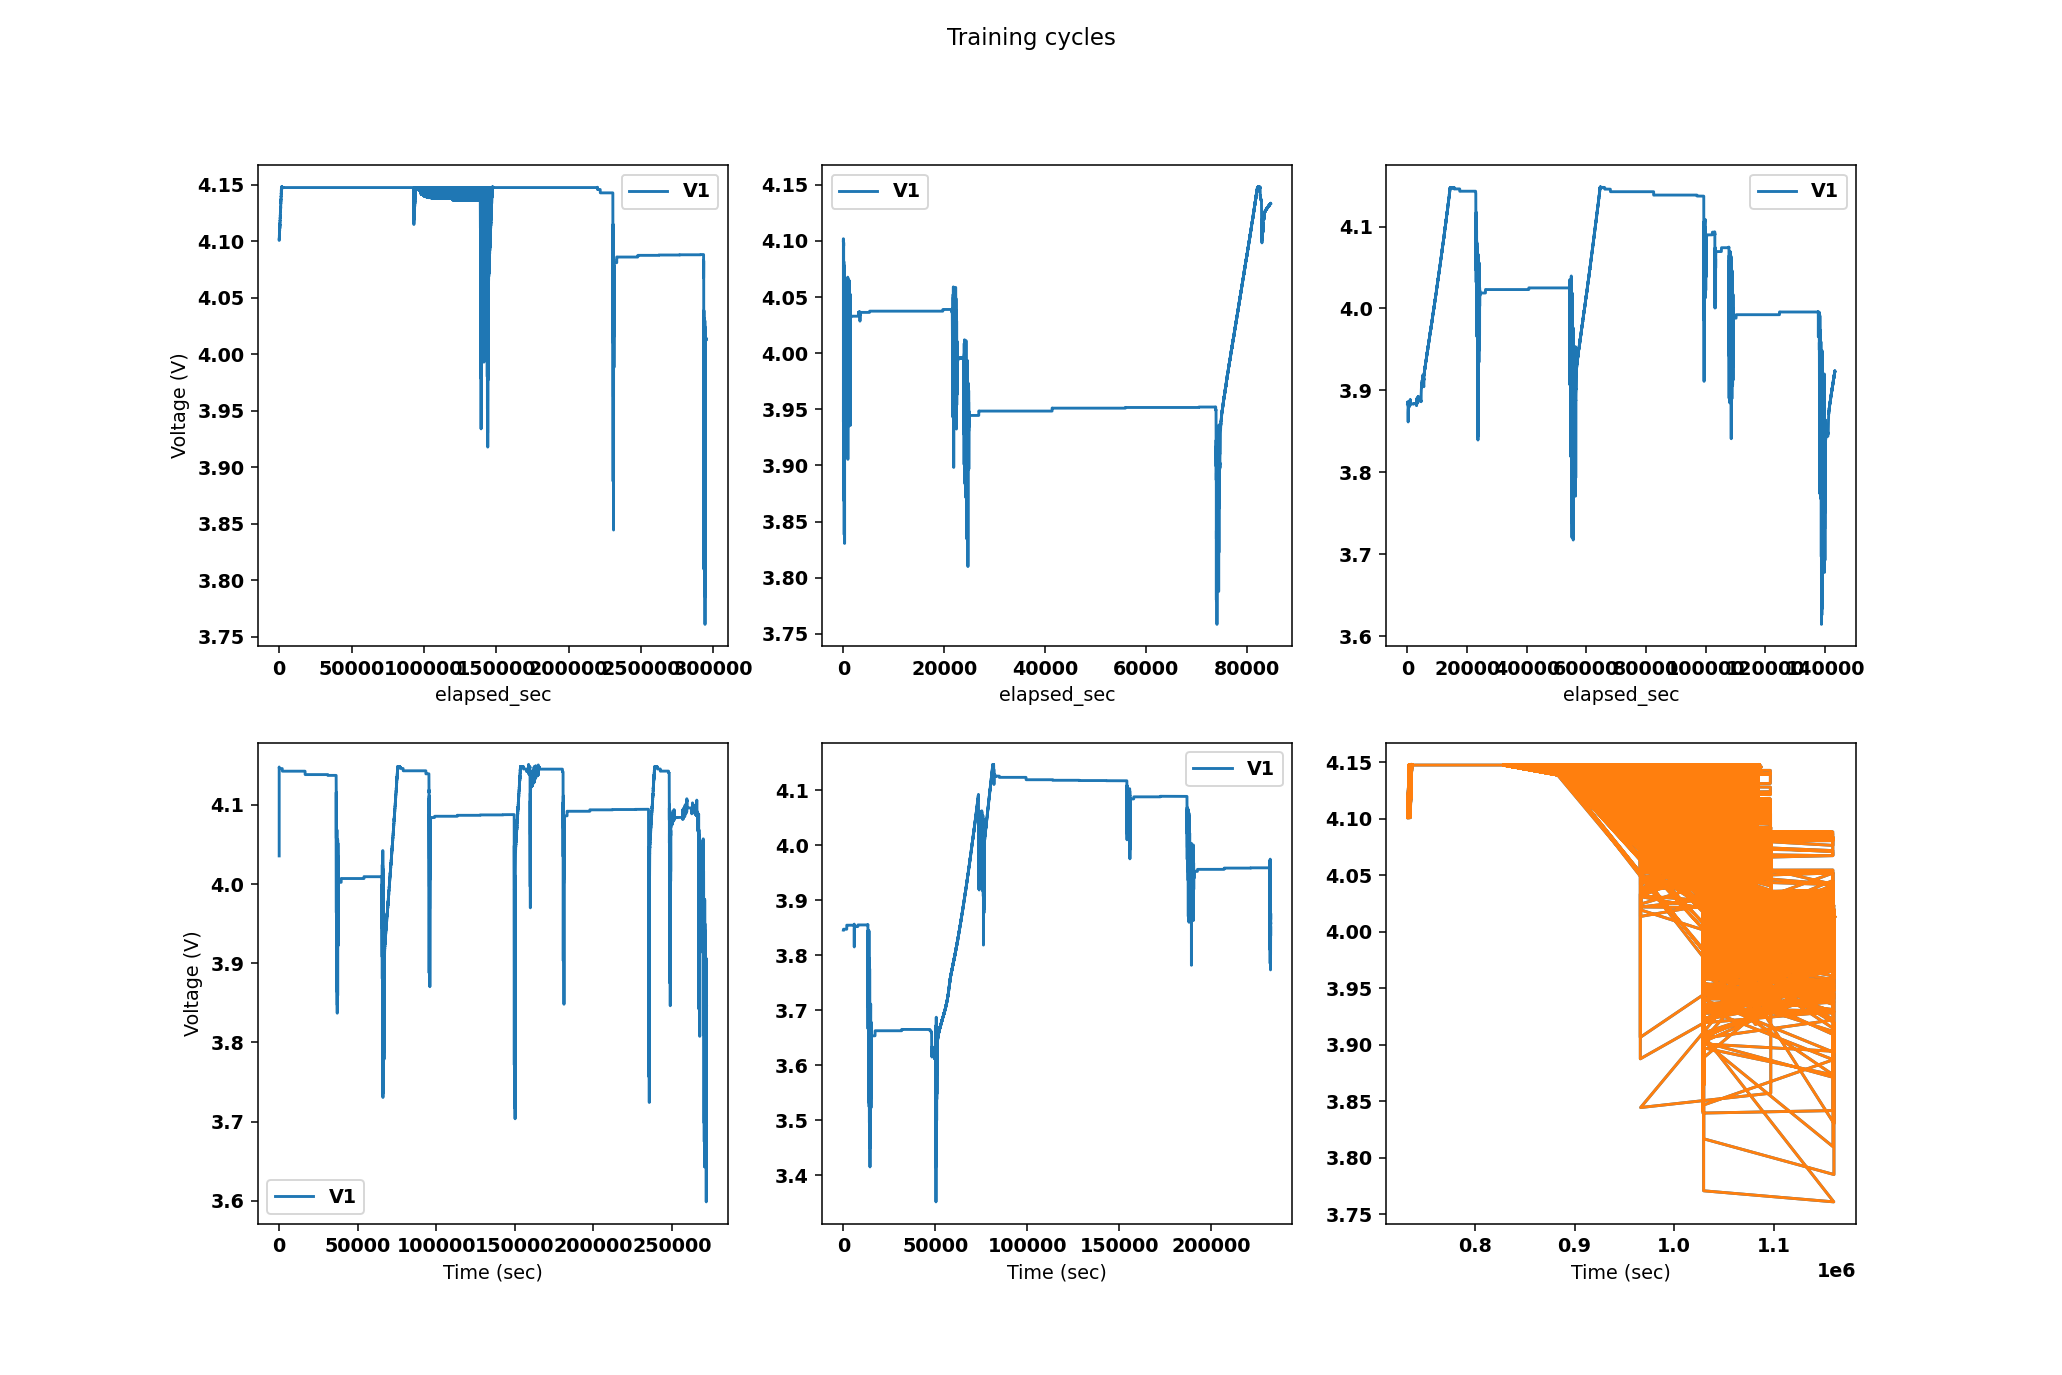

i:  0   j:  0
i:  0   j:  1
i:  0   j:  2
i:  1   j:  0
i:  1   j:  1


In [14]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# set save path for plot
fig_path = os.path.join(cwd, 'figures')
plot_path = os.path.join(fig_path, 'test.pdf')

cols = 3
total_train_cycles = len(li_ts_segments)
rows = math.ceil(total_train_cycles / cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

i = -1        # row index
j = 0        # col index
# Plot multiple train cycles voltages
for df in li_ts_segments:
    if (j % cols == 0):
        j = 0
        i += 1     # first entrance makes i = 0
    print('i: ', i, '  j: ', j)
    df_each = df.copy()
    df_each.plot(x='elapsed_sec', y='V1', ax = axes[i][j], title='Training cycles', subplots=True)
#     ax.set_title(f'Title {i}')
    j += 1

# set labels
plt.setp(axes[-1, :], xlabel='Time (sec)')
plt.setp(axes[:, 0], ylabel='Voltage (V)')
plt.show()
plt.savefig(plot_path)

In [174]:
# For each segment only find dynamic portions, and static portions separately

CONTACTOR_ON = 2
CONTACTOR_OFF = 0

# li_ts_segments[0]['timestamp'].is_monotonic_increasing
li_cntr_off = []

for df in li_ts_segments:
    df_x = df.copy()
    dfx_cntr_off = df_x.loc[df_x['contactor_state'].astype('int64') == constants.CONTACTOR_OFF].copy()
    tu_time_divided_ts = data_preprocess.get_ts_records_by_timegap(dfx_cntr_off, 'timestamp', 1)
    break
#     li_cntr_off.append(dfx_cntr_off)

print(len(tu_time_divided_ts))

10707


In [9]:
# phase 3 data load

import pickle

# load last saved df from phase1 data as segments of freq 1 Hz
dir_path = os.path.join(cwd, 'csv', 'phase_3_pkl')
src_path = os.path.join(dir_path, '300ms_synced_29_03_01_06_may.pkl')

with open(src_path, 'rb') as f:
    df = pickle.load(f)
# print(df.head(10))

In [10]:
# rename columns
df.rename(columns = {
    'time':'timestamp',
    'current_BMS01':'current',
    'brickVoltage007_BMS01':'V',
    'minSOC_BMS01':'min_SOC',
    'minSOH_BMS01':'min_SOH',
    'contactorState_BMS01':'contactor_state',
    'moduleTemperature01_BMS01': 'Temp'
    }, inplace = True)


In [11]:
# Keep only necessary columns
df = df[['timestamp', 'current', 'min_SOC', 'min_SOH', 'contactor_state', 'V', 'Temp']]

In [178]:
# print(df['contactor_state'])

In [12]:
# segment by 1 Hz
tu_time_divided_ts = data_preprocess.get_ts_records_by_timegap(df.copy(), 'timestamp', 1)
print(len(tu_time_divided_ts))

806


In [13]:

li_1s_segments = []
for df in tu_time_divided_ts:
    df_temp = df.copy()
    df_temp.timestamp = pd.to_datetime(df_temp['timestamp'], format="%Y-%m-%d %H:%M:%S:%f")       # .f for milliseconds
    df_temp = df_temp.set_index(["timestamp"])
    df_resample = df_temp.resample('1S').last().bfill(axis ='rows').reset_index()
    li_1s_segments.append(df_resample)

In [14]:
# remove the very small time segments, keep only segments that are longer than 15 minutes
li_ts = []
for df in li_1s_segments:
    if len(df) > 1000:
        li_ts.append(df.copy())
print(len(li_ts))

137


In [15]:
# replace NAN from contactor_state
li_filled = []
for df in li_ts:
    df_each = df.copy()
    if (df_each['contactor_state'].isna().sum()) > 0:
        df_each['contactor_state'].ffill(inplace=True)
    li_filled.append(df_each)

               timestamp  current  min_SOC  min_SOH  contactor_state       V  \
0    2022-03-30 09:13:30      0.0   655.35     99.0              0.0  4.1315   
1    2022-03-30 09:13:31      0.0    99.80     99.0              0.0  4.1315   
2    2022-03-30 09:13:32      0.0    99.80     99.0              0.0  4.1316   
3    2022-03-30 09:13:33      0.0    99.80     99.0              0.0  4.1316   
4    2022-03-30 09:13:34      0.0    99.80     99.0              0.0  4.1315   
...                  ...      ...      ...      ...              ...     ...   
9576 2022-03-30 11:53:06     -1.7    97.93     99.0              2.0  4.1067   
9577 2022-03-30 11:53:07     -1.7    97.93     99.0              2.0  4.1067   
9578 2022-03-30 11:53:08     -1.7    97.93     99.0              2.0  4.1067   
9579 2022-03-30 11:53:09     -1.7    97.92     99.0              2.0  4.1067   
9580 2022-03-30 11:53:10     -0.2    97.92     99.0              2.0  4.1076   

      Temp  time_group  
0      NaN    

<IPython.core.display.Javascript object>


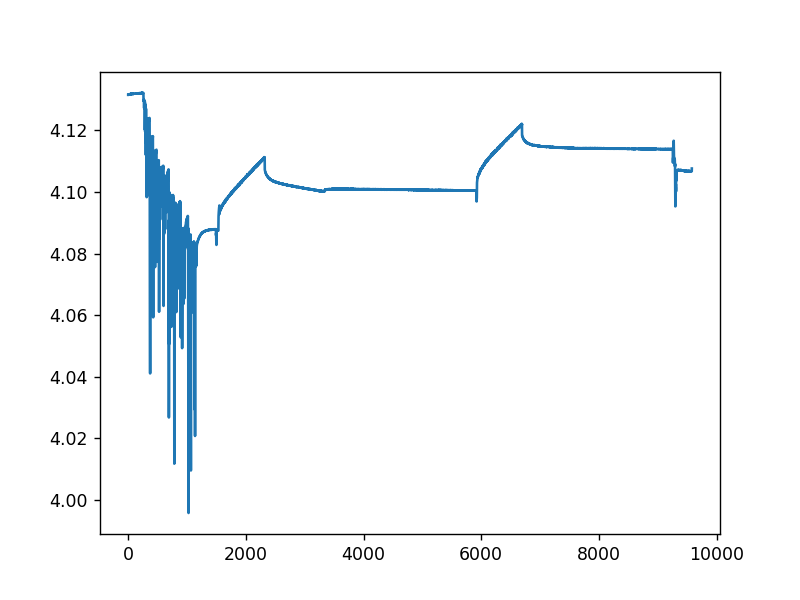

<AxesSubplot:>

In [16]:
%matplotlib notebook
# test plot an element
print(li_filled[0])
li_filled[0]['V'].plot()

In [17]:
# get sequence that have both contactor on and off
li_ts_segments = data_preprocess.get_continuous_ts_segments_list(li_filled)
li_ts_segments = [data_preprocess.add_elapsed_sec(each_df, 'timestamp') for each_df in li_ts_segments] # Add elapsed time for plotting and other reasons

In [22]:
li_ts_segments[0]['timestamp'].is_monotonic_increasing
for ts in li_ts_segments:
    print(ts)
    break

               timestamp  current  min_SOC  min_SOH  contactor_state       V  \
0    2022-03-30 09:13:30      0.0   655.35     99.0              0.0  4.1315   
1    2022-03-30 09:13:31      0.0    99.80     99.0              0.0  4.1315   
2    2022-03-30 09:13:32      0.0    99.80     99.0              0.0  4.1316   
3    2022-03-30 09:13:33      0.0    99.80     99.0              0.0  4.1316   
4    2022-03-30 09:13:34      0.0    99.80     99.0              0.0  4.1315   
...                  ...      ...      ...      ...              ...     ...   
9576 2022-03-30 11:53:06     -1.7    97.93     99.0              2.0  4.1067   
9577 2022-03-30 11:53:07     -1.7    97.93     99.0              2.0  4.1067   
9578 2022-03-30 11:53:08     -1.7    97.93     99.0              2.0  4.1067   
9579 2022-03-30 11:53:09     -1.7    97.92     99.0              2.0  4.1067   
9580 2022-03-30 11:53:10     -0.2    97.92     99.0              2.0  4.1076   

      Temp  time_group  elapsed_sec  
0

In [19]:
# insert dfs into a list
li_full_cycle = []           # each element is a df containing a ful cycle in sequence: static + dynamic + static
for i in range(len(li_ts_segments)):
    df_temp = li_ts_segments[i].copy()
    li_full_cycle += data_preprocess.get_full_cycles_list(df_temp, 'contactor_state', 'timestamp')

print(len(li_full_cycle))
# print(type(li_full_cycle[0]))   # each element is a dataframe

0
